# Additional Assesment
## Demand Forecasting

by Tanat Metmaolee

__Goal__: To predict 3 months of item-level sales data at different store locations

### Questions
1. item-level sales data at different stores = each item in each store prediction?
2. The csv file is cube-based with 10 stores and 50 products in each store, there will be about 90 days of 500 predictions? 
3. Is there any packages you require me to use, or any packages that can't be used?
4. Or any suggestions?
4. Planning to finish the tasks with this weekend, how long would the review takes? 

### Packages

In [194]:
# Data Analysis
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Statistics
from scipy import stats
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import accuracy_score

## Data Collection

In [152]:
raw_df = pd.read_csv('demand-forecasting/train.csv')

In [153]:
test_df = pd.read_csv('demand-forecasting/test.csv')

## Data Preprocessing/Cleaning

### Dataset Structure

In [154]:
# Preview
raw_df.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [155]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


### Null/Na values check

In [156]:
raw_df.isna().sum()

date     0
store    0
item     0
sales    0
dtype: int64

In [157]:
raw_df.isnull().sum()

date     0
store    0
item     0
sales    0
dtype: int64

### Unique Values

In [158]:
raw_df['item'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50])

In [159]:
raw_df['store'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

### Outliers

Things that might need to be checked
- Z Score
- Interquartile

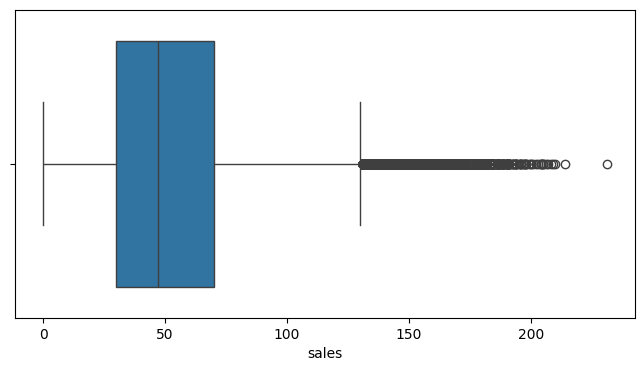

In [160]:
plt.figure(figsize=(8, 4))
sns.boxplot(x=raw_df['sales'])
plt.show()

`store`, `item` Features shouldn't have any problem since they're discrete. 

We only need to fix `date` Feature.

### `date` format approach

1. Store each store's product in Python dictionary
2. Use in-built pandas Method -> `pd.to_datetime()` then Split or add column as `day` `Month` `Year`

In [176]:
df = raw_df
df['date'] = pd.to_datetime(df['date'])

In [178]:
df['day_of_week'] = df['date'].dt.day_of_week
df['day_of_month'] = df['date'].dt.day
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year

In [179]:
df = df.drop('date', axis=1)

#### Dictionary Approach

In [164]:
def store_split(df) -> dict:
    store_len = len(df['store'].unique())
    item_len = len(df['item'].unique())
    store = {}
    for i in range(1, store_len + 1):
        store[i] = {}
        for j in range(1, item_len + 1):
            store[i][j] = df[(df['store'] == i) & (df['item'] == j)]
    return store

In [165]:
stores = store_split(df)

Now we can access each store's product with `stores[store_number][item_number]`

In [166]:
stores[10][10].head(10)

,store,item,sales,day_of_week,day_of_month,month,year
180774,10,10,45,1,31,1,2013
180775,10,10,50,2,31,1,2013
180776,10,10,53,3,31,1,2013
180777,10,10,51,4,31,1,2013
180778,10,10,54,5,31,1,2013
180779,10,10,54,6,31,1,2013
180780,10,10,54,0,31,1,2013
180781,10,10,40,1,31,1,2013
180782,10,10,50,2,31,1,2013
180783,10,10,53,3,31,1,2013


In [167]:
len(stores[10][10])

1826

#### Alternative Approach (Use pandas to drill down the date feature)

In [188]:
grouped_df = df[df['store'] == 1]
grouped_df

,store,item,sales,day_of_week,day_of_month,month,year
0,1,1,13,1,1,1,2013
1,1,1,11,2,2,1,2013
2,1,1,14,3,3,1,2013
3,1,1,13,4,4,1,2013
4,1,1,10,5,5,1,2013
...,...,...,...,...,...,...,...
896561,1,50,38,2,27,12,2017
896562,1,50,52,3,28,12,2017
896563,1,50,59,4,29,12,2017
896564,1,50,66,5,30,12,2017


In [184]:
grouped_df = df[(df['store'] == 1) & (df['item'] == 1)]
grouped_df

,store,item,sales,day_of_week,day_of_month,month,year
0,1,1,13,1,1,1,2013
1,1,1,11,2,2,1,2013
2,1,1,14,3,3,1,2013
3,1,1,13,4,4,1,2013
4,1,1,10,5,5,1,2013
...,...,...,...,...,...,...,...
1821,1,1,14,2,27,12,2017
1822,1,1,19,3,28,12,2017
1823,1,1,15,4,29,12,2017
1824,1,1,27,5,30,12,2017


### Lag Features
This is used specifically for time series Financial Analysis

## EDA

In [189]:
df.describe()

,store,item,sales,day_of_week,day_of_month,month,year
count,913000.000000,913000.000000,913000.000000,913000.000000,913000.000000,913000.000000,913000.000000
mean,5.500000,25.500000,52.250287,3.001643,15.727820,6.523549,2015.000548
std,2.872283,14.430878,28.801144,1.999316,8.799329,3.448535,1.414021
min,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,2013.000000
25%,3.000000,13.000000,30.000000,1.000000,8.000000,4.000000,2014.000000
50%,5.500000,25.500000,47.000000,3.000000,16.000000,7.000000,2015.000000
75%,8.000000,38.000000,70.000000,5.000000,23.000000,10.000000,2016.000000
max,10.000000,50.000000,231.000000,6.000000,31.000000,12.000000,2017.000000


### Correlation

#### Factors that might affect the sales
1. The location of the store
2. Difference items in each store has different sales value depending on each seasons
3. The date (Promotion Day, Season Sales Day, Weekday, Weekend, Season Demanding)


In [190]:
correlation_matrix = df.corr()
correlation_matrix

,store,item,sales,day_of_week,day_of_month,month,year
store,1.000000e+00,7.276042e-15,-0.008170,4.363596e-16,-4.920966e-16,-4.500688e-16,1.349957e-13
item,7.276042e-15,1.000000e+00,-0.055998,1.643582e-14,-2.945987e-14,4.093306e-15,1.908796e-11
sales,-8.170361e-03,-5.599807e-02,1.000000,2.226076e-01,2.791264e-03,8.741417e-02,1.823597e-01
day_of_week,4.363596e-16,1.643582e-14,0.222608,1.000000e+00,7.725204e-04,-1.475063e-03,2.711688e-03
day_of_month,-4.920966e-16,-2.945987e-14,0.002791,7.725204e-04,1.000000e+00,1.079604e-02,5.841665e-04
month,-4.500688e-16,4.093306e-15,0.087414,-1.475063e-03,1.079604e-02,1.000000e+00,-5.080291e-04
year,1.349957e-13,1.908796e-11,0.182360,2.711688e-03,5.841665e-04,-5.080291e-04,1.000000e+00


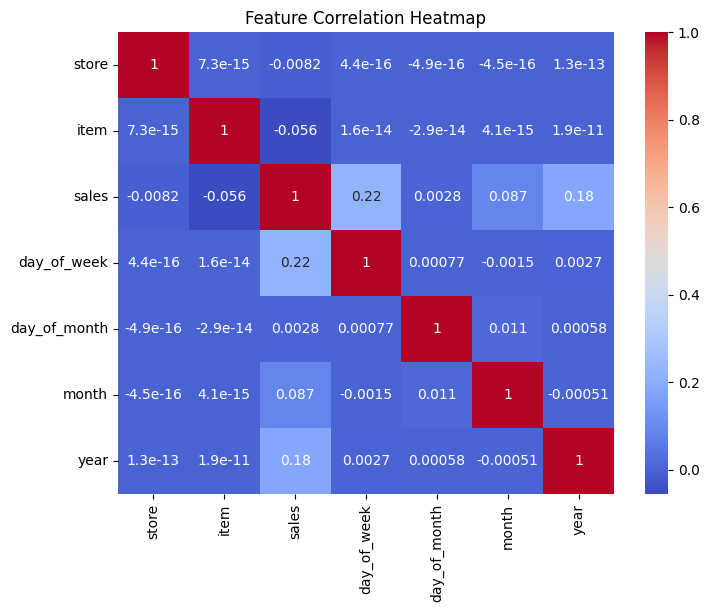

In [191]:
plt.figure(figsize=(8,6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

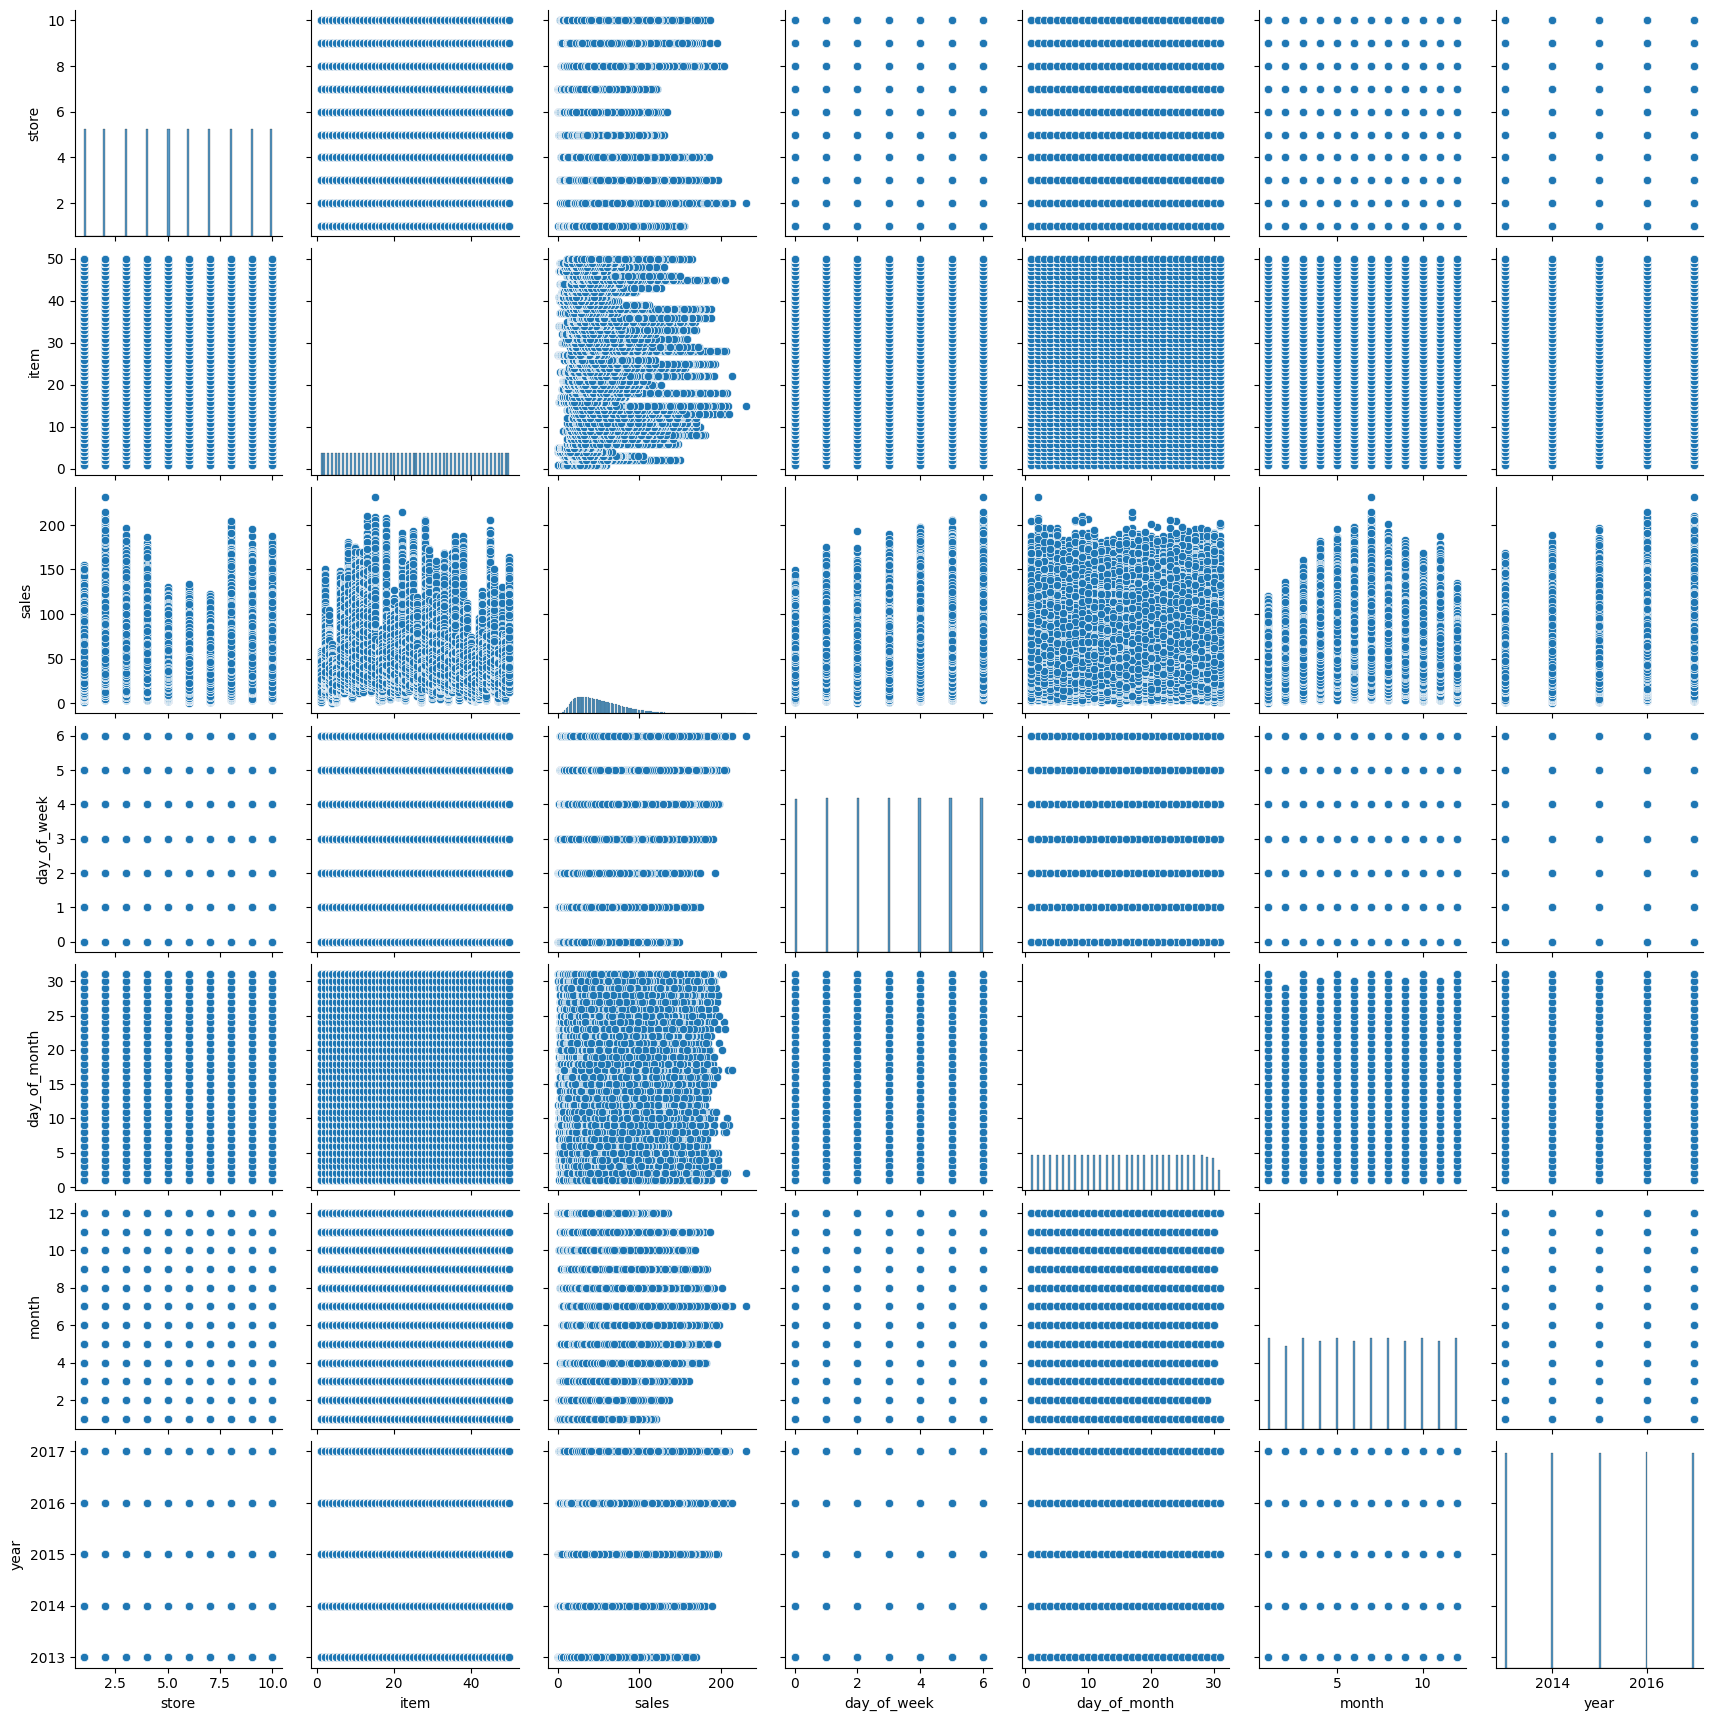

In [192]:
sns.pairplot(df)
plt.show()

In [174]:
plt.figure(figsize=(8, 6))
plt.plot(stores[1][1]['date'], stores[1][1]['sales'])
plt.title('days to sales plot')
plt.xlabel('date')
plt.ylabel('sales')
plt.show()

KeyError: 'date'

<Figure size 800x600 with 0 Axes>

### Sales Distribution

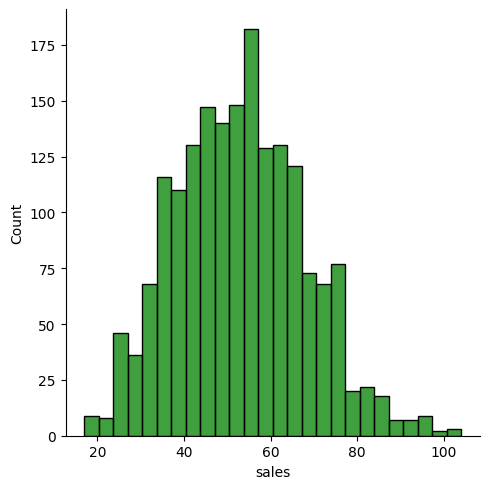

In [ ]:
sns.displot(stores[1][6]['sales'], color='green')
plt.show()

## Model Building

In [ ]:
epochs = 1000
learning_rate = 0.01

In [ ]:
X = df.drop(['sales'], axis=1)
y = df['sales']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=66)

### Training

In [193]:
model = XGBRegressor(n_estimators=epochs, learning_rate= learning_rate)

### Testing

## Deployment